# PyceCREAM

Here is a python implementaiton of my accretion disc and emission line lightcurve-fitting code (previously CREAM). This guide briefly covers generating synthetic data and calling a new pycecream object to ingest and fit the accretion disc model (or emission line model) to a set of input light curves. I also demonstrate how to access the output of the pycecream fit. The output includes the fitted light curves, any new light curve data points after merging, fitted response functions and parameter MCMC chain histories for the disc and/or tophat response parameters.

Most of these features are used in some form or another from a previous f90 version of this code (CREAM) in the following literature

* Grier et al in prep
* Grier et al 2018    https://iopscience.iop.org/article/10.3847/1538-4357/aa98dc/pdf
* Starkey et al 2017  https://ui.adsabs.harvard.edu/#abs/arXiv:1611.06051
* Starkey et al 2016  https://ui.adsabs.harvard.edu/#abs/arXiv:1511.06162

Please send questions to ds207@st-andrews.ac.uk. Though I am currently taking a break from academia and may take some time to respond, I will try to do so as soon as possible.


## Requirements & Installation

Please ensure that you have a fortran compiler installed. I use Gfortran. If you have an alternate (e.g ifort), please indicate the standard command used to call the fortran compiler using the ```fortran_caller``` argument (default is ```fortran_caller = gfortran```).


command These are fairly easy to install from macports or wget etc. Also a Python version is required (I am using 3.7 but even 2 should be fine). The it's just...

```
pip install pycecream
```


#  Section 1: Generate Synthetic Light Curves

In this example we generate 4 disk light curves and 2 emission-line light curves modelled as a top-hat with a 20-day lag. The code below generates a list where each index contains an Nx3 numpy array for each light curve. The 3 vertical axis for each light curve are the time, flux and noise respectively (query synthetic_data['echo lightcurves'][0] for an example of the format required when inputting your own light curve data).

The example below combines continuum and line light curves and illustrates a case in which you may have two of the same emission line (and so want to fit with the same response function model) but observed from different telescopes that require seperate noise models.

In [1]:
import astropy_stark.myfake as mf
import matplotlib.pylab as plt

'''
mf.myfake arguments are

wavelengths: enter the wavelengths (-1 indicates an emission line light curve modelled with a top-hat response),

snr: set the signal-to-noise relative to light curve rms

cadence:set the mean cadence

top hat centroid: set the centroid for the top-hat (I think thats what this does but the line lag 
thing is still newish so Im used to just making continuum light curve)
'''


synthetic_data = mf.myfake(
    [4000.0,5000.0,5000.0,7000.0,-1.0,-1.0],
    [50.0,50.0,10.0,50.0,50,10.],
    [1.0,1.0,2.0,1.0,1.0,3.0],
    thcent = 20.0
)

'''This recovers the synthetic data'''
dat = synthetic_data['echo light curves']

#  Section 2: Settup and run PyceCREAM



In [2]:
import pycecream

#instantiate a pycecream object
a = pycecream.pycecream()

'''
If you use a fortran compiler other than gfortran please indicate here.
I just re-enter gfortran here for demonstration purposes even though 
this is unecassary as gfortran is the default argument.
'''
a.fortran_caller = 'gfortran'



'''Choose an output directory in which to save the results. 
This will be a new directory that you have not previously created (pycecream will make it automatically).

NOTE: Each new cream simulation must have a new name for "output_directory argument below 
otherwise an excpetion is raised. This is to prevent accidentally overwriting previous simulations. 
I might change this in a future version 
'''
a.output_directory = 'fit_synthetic_lightcurves'



'''
Add each of the light curves in the simulation. 
In this case we are using the "dat" output from the synthetic data above.
'''
a.add_lc(dat[0], name = 'continuum 4000')
a.add_lc(dat[1], name = 'continuum 5000')
a.add_lc(dat[2], name = 'continuum 5000 (b)')
a.add_lc(dat[3], name = 'continuum 7000')

#If adding a line light curve, must indicate using the "kind" argument
a.add_lc(dat[4],name='test line 1',kind='line')

#If we want the same line response function model, set "share_previous_lag"=True
a.add_lc(dat[5],name='test line 1 (shared)',kind='line',share_previous_lag=True)



'''
specify the numnber of MCMC iterations. Normally at least several thousand are necessary but shorter numbers 
can be used just to check everything is working is done here.
'''
a.N_iterations=40

'''
specify the step sizes for the fit parameters. 
Here we are setting the accretion rate step size to vary by ~ 0.1 solar masses per year.
'''
a.p_accretion_rate_step = 0.1

'''
Check the input settings are ok prior to running
'''
print(a.lightcurve_input_params)

'''
RUN!
'''
a.run()

pycecream path... /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pycecream
copying file...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pycecream
                   name  type  wavelength            noise model  \
0        continuum 4000  line        -1.0  [var, multiplicative]   
0        continuum 5000  line        -1.0  [var, multiplicative]   
0    continuum 5000 (b)  line        -1.0  [var, multiplicative]   
0        continuum 7000  line        -1.0  [var, multiplicative]   
0           test line 1  line        -1.0  [var, multiplicative]   
0  test line 1 (shared)  line        -1.0  [var, multiplicative]   

  share previous lag temporary file name      mean  standard deviation  \
0              False          line_0.dat  3.797598            0.791625   
0              False          line_1.dat  3.588153            0.673253   
0              False          line_2.dat  3.587092            0.675741   
0              Fa

# Section 3: Examine the output

There are 2 output dataframes.

## 1) output_lightcurves = a.get_light_curve_fits():
This a dictionary of 3 data frames.

    1.1) output_lightcurves['model']: standard time, model, error envelope for each file

    1.2) output_lightcurves['merged model'] AS above but with the error bars, vertical and horrizontal scalings applied relative to the reference model. Not sure but I think the reference model defaults to the first occurence of a particular wavelength in the order that it was added in self.add_lc

    1.3) output_lightcurves['merged data'] DICTIONARY (since the input data light curves can be different sizes) The same transformations but applied to the input light curve data. useful if using cream only to merge the orriginal light curves from different telescopes to a new scale for further study elsewhere

## 2) output_chains = a.get_MCMC_chains(): 
These are the MCMC chains for each parameter.


cream_lcplot plotting results from... fit_synthetic_lightcurves/simulation_files


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3199: RuntimeWarning: invalid value encountered in double_scalars
  low = [thisx - thiserr for thisx, thiserr


-15.6157398 [3.79759836 3.79759836 3.79759836 3.79759836 3.79759836] 0
-15.6157398 [2.97298455 2.97860861 2.98250675 2.98431969 2.98378778] 1
-15.6157398 [2.98830366 2.99381804 2.99764013 2.9994173  2.99889588] 2
-15.6157398 [2.81484246 2.81997252 2.82417488 2.82705927 2.82838535] 3
making posterior plot.... posterior_fit_figures__1.pdf
unable to make covariance plot for disc posteriors. Please check at least some of these are set to varyin the fit.
fit_synthetic_lightcurves/simulation_files/output_20190406_001/G_plot.pdf
Nth  6  Ndisk 1
cream_lcplot plotting results from... fit_synthetic_lightcurves/simulation_files/output_20190406_001
-15.6157398 [3.79759836 3.79759836 3.79759836 3.79759836 3.79759836] 0
-15.6157398 [2.97298455 2.97860861 2.98250675 2.98431969 2.98378778] 1
-15.6157398 [2.98830366 2.99381804 2.99764013 2.9994173  2.99889588] 2
-15.6157398 [2.81484246 2.81997252 2.82417488 2.82705927 2.82838535] 3


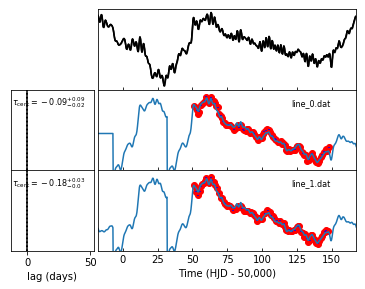

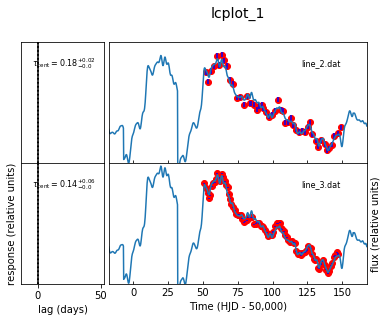

cream_lcplot plotting results from... fit_synthetic_lightcurves/simulation_files/output_20190406_001


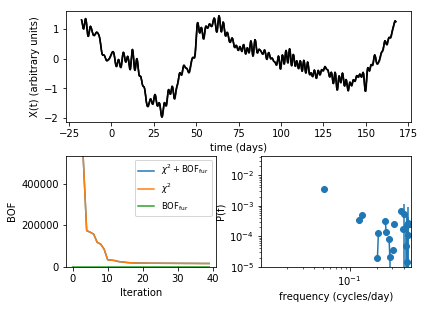

cream_lcplot plotting results from... fit_synthetic_lightcurves/simulation_files/output_20190406_001


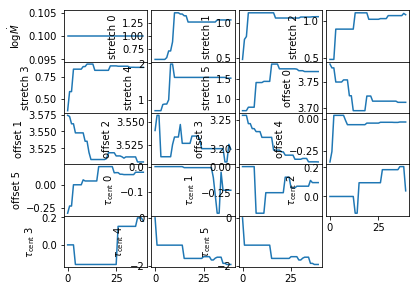

cream_lcplot plotting results from... fit_synthetic_lightcurves/simulation_files/output_20190406_001


In [3]:
'''
Get the mcmc chains and output fits. 
Each of these arguments come with a "location" argument where you can point to a 
previous simulation and recover the outputs. 
If this is left blank we default to the current simulation
'''
output_chains = a.get_MCMC_chains(location = None)
output_lightcurves = a.get_light_curve_fits(location = None)

'''
make figures of the fit, posterior, light curves etc. file prefix tells the code where you want to save the output.
The figure plotting is somewhat primitive and is a relic of when I still used cream. You may prefer to use your own
output figures with the output of the "get_MCMC_chains" and "get_light_curve_fits" functions above.
'''
a.plot_results(file_prefix='fit_figures')




'''
figures can also be made on an indivdual basis with axes objects returned from python plotting functions
'''
#plot the fitted light curves.
a.plot_lightcurves()
plt.show()


#plot the driving light curve
a.plot_driver()
plt.show()


#plot the parameter trace plots
a.plot_trace()
plt.show()


#plot the covariance parameter plot for the disc parameters
a.plot_posterior()
plt.show()




In [4]:
# how to install python 3 environment (skip the netcdf4 line) matplotlib should be ok now
# https://salishsea-meopar-docs.readthedocs.io/en/latest/work_env/python3_conda_environment.html


# Section 4: Using PyceCREAM to merge light curves only.

In this section, we explore another application of cream, merging light curves. I may for example have light curves taken all at a single wavelength but from different telescopes. I want to calibrate and merge these together using PyceCREAM to then produce a single light curve file to pass onto further analysis elsewhere. 

I will create two example line light curves below seperated by 15 days.

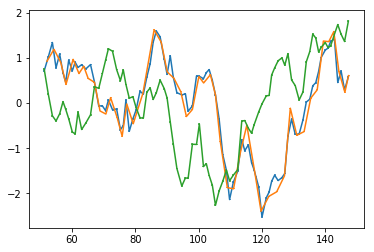

In [5]:
#create the fake data.
'''
 For some reason my fake data creator wasnt designed to make multiple line light curves with different lags
 at the same time so I have faked it out below by recreating the same driver twice using the same random 
 number seed to create each lag.
'''
#this will create two light curves with a standard deviation of 1 and a mean of 0, SNR of 50
#sampled at 1 and 2 day mean cadence
lc1 = mf.myfake(
    [-1.0,-1.0],
    [50.0,50.],
    [1.0,2.0],
    sdforcein=[1.0,1.0],
    meanforcein = [0.0,0.0],
    thcent = 5.0,
    iseed = 12345
)['echo light curves']

#this will create one further light curve with a standard deviation of 2 and a mean of 5, SNR of 20
#sampled at 1 day mean cadence. This will have the same lag as the first light curve to indicate the same filter
#but have a different vertical and noise model to indicate a calibration issue.
lc2= mf.myfake(
    [-1.0],
    [20.0],
    [1.0],
    thcent = 5.0,
    sdforcein=[2.0],
    meanforcein = [5.0],
    iseed = 12345
)['echo light curves']
linedat = lc1+lc2


#plot the light curves here to demonstrate
fig = plt.figure()
ax1 = fig.add_subplot(111)
label = ['telescope 1']*len(lc1) + ['telescope 2']*len(lc2)
for i in range(len(linedat)):
    ax1.errorbar(linedat[i][:,0],linedat[i][:,1],linedat[i][:,2],ls=None)
ax1.set_xlabel('time (days)')
ax1.set_ylabel('flux arbitrary units')
plt.legend()
plt.show()



## Initialise the cream instance and configure for merge mode 

I dont bother here with all the setup commands like a.fortran_caller. Please see Section 2 for the cream system configuration settings (these tend to be unecessary anyway). 

In [ ]:

#instantiate a pycecream object
a = pycecream.pycecream()

a.output_directory = 'merge_line_lightcurves'


'''
add the light curves. This is where the difference lies. Remember the first 2 light curves from linedat
are from one telescope and the 3rd is from another. We want to merge these together
'''

'''We add the line light curves in the same way as before but
first we force the default line lag step size to be zero, and then make all the subsequent 
light curves share this lag. This has the effect of forcing the pycecream not to fit a lag
(or at least a delta function forced on zero) and only optimize the noise model.
'''
a.p_linelag_centroids_step = 0.0
a.add_lc(linedat[0],name='line 1 (telescope 1)',kind='line')
a.add_lc(linedat[0],name='line 2 (telescope 1)',kind='line',share_previous_lag=True)
a.add_lc(linedat[0],name='line 3 (telescope 2)',kind='line',share_previous_lag=True)



'''
RUN!
'''
a.run()


# Configurable parameters

Here is a list of all creams default parameters. Modify these after instantiting a pycecream object. By defaut for example, pycecream does not optimise the inclination and assumes face-on. To change this, begin with, 


```
a = pycecream.pycecream()
a.p_inclination_step = 0.1 
```

This will alter the cosine inclination step size to 0.1. To fix the inclination at some other value (e.g 30 degrees) but not optimise use,

```
a.p_inclination = 30.0
a.p_inclination_step = 0.0 
```


In [ ]:
#global non-fitted parameters

'''Below is the upper fourier frequency limit in cycles per day. Lower this if you have sparesely 
sampled data or the fit is taking too long. Going less than 0.3 days tends to mess up 
inferences on disk inclination
'''
self.high_frequency = 0.5

self.redshift = 0.0
self.bh_mass = 1.e7
self.bh_efficieny = 0.1
self.N_iterations = 1000
self.lag_lims = [-10.0,50.0] #the window for the response function

#fitted parameters
self.p_inclination = 0.0
self.p_inclination_step = 0.0
self.p_accretion_rate = 0.1
self.p_accretion_rate_step = 0.0
self.p_viscous_slope = 0.75
self.p_viscous_slope_step = 0.0
self.p_extra_variance_step = 0.1

#non configureable parameters. Dont usually mess with these
self.p_linelag_centroids_start = 0.0
self.p_linelag_centroids_step = 5.0
self.p_linelag_widths_start    = 2.0
self.p_linelag_widths_step = 0.0